In [1]:
import numpy as np
import pandas as pd
import nba_on_court as noc
import seaborn as sns
from sklearn.linear_model import RidgeCV

This code fits a ridge model from a 3rd party source (see https://github.com/SCOREnetworkorg/sports-data-repository/blob/main/basketball/nba-rapm-data.qmd).

I'm primarily using this to compare my results with another source's results on the same data.

# Fit the Model

In [2]:
data = pd.read_csv('../../design_matrices/nba_2223_season_rapm_data.csv.gz')

design = data.drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)
target = data['margin']

hyperparameters = pd.read_csv('../../results/hyperparameters.csv')

hyperparameters

,.
0,48.547966
1,47.714705
2,46.895746
3,46.090843
4,45.299755
...,...
395,0.052029
396,0.051136
397,0.050258
398,0.049396


In [3]:
hypers = [1000, 1500, 2000, 2500, 3000]

model = RidgeCV(
    alphas=hypers,
    fit_intercept=False, # my model uses a signed intercept
).fit(design, target, sample_weight=data['minutes'])

In [4]:
results = pd.read_csv('../../data/nba_2223_player_table.csv')
results['RAPM'] = model.coef_ # note that the interpretation of stints is very different here!

model.alpha_

1500

,player_id,player_name,RAPM
2,1628389,Bam Adebayo,2.455016
4,1630583,Santi Aldama,0.797916
5,1629638,Nickeil Alexander-Walker,-1.287850
6,1628960,Grayson Allen,-1.368234
7,1628386,Jarrett Allen,-1.665822
...,...,...,...
524,1629057,Robert Williams III,-0.231365
535,1629027,Trae Young,0.095542
536,1630209,Omer Yurtseven,0.262952
537,203469,Cody Zeller,-0.089495


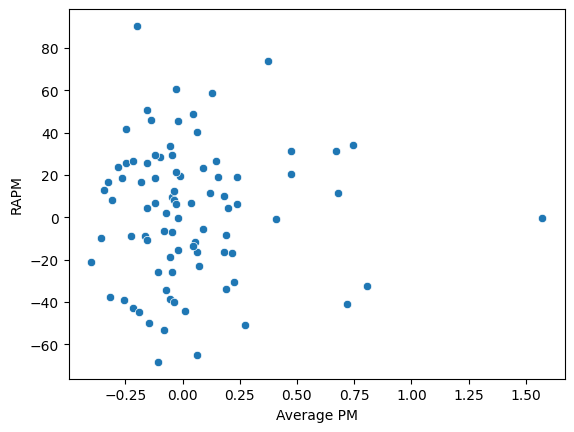

In [5]:
my_results = pd.read_csv('../../results/signed_indicator_results.csv', index_col=0)

players = np.intersect1d(my_results['Player'].values, results['player_name'].values)
results = results[results['player_name'].isin(players)]
my_results = my_results[my_results['Player'].isin(players)]

results.to_csv('../../results/ryurko_results.csv')
sns.scatterplot(x=100 * my_results['Average PM'], y=30 * results['RAPM'])

results

In [6]:
results.sort_values(by='RAPM').tail(50)

,player_id,player_name,RAPM
308,1628997,Caleb Martin,0.631111
201,1630573,Sam Hauser,0.634036
35,1627736,Malik Beasley,0.637620
381,1627780,Gary Payton II,0.640485
327,1629162,Jordan McLaughlin,0.640743
361,1630192,Zeke Nnaji,0.645093
94,1629599,Amir Coffey,0.651760
504,1631212,Peyton Watson,0.677010
62,1627759,Jaylen Brown,0.679465
184,1629060,Rui Hachimura,0.707888
